In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from scipy.ndimage import zoom

## Rescale the original grid_delta_1.npy file

In [2]:
rescale_IDs = [0,1,2,3,4]
element_density_ls = [0.05, 0.4, 0.1, 0.3, 0.04]
element_ls = ["Al", "Si", "P", "Ca", "Sc"]
sample_height_n = 64
sample_size_n = 64
for rescale_ID in rescale_IDs:
    densities = np.load(f"../grid_delta/grid_delta_{rescale_ID}.npy").astype(np.float32)
    densities = densities * (element_density_ls[rescale_ID] / np.max(densities))
    elements = np.array(element_ls).astype("S5")
    

    with h5py.File(f'density_element_{rescale_ID}.h5', 'w') as s:
        sample = s.create_group("sample")
        sample_v = sample.create_dataset("densities", shape=(sample_height_n, sample_size_n, sample_size_n), dtype="f4")
        sample_e = sample.create_dataset("elements", shape=(1,), dtype='S5')
        sample_v[...] = densities
        sample_e[...] = np.array(element_ls[rescale_ID]).astype('S5')

In [3]:
rescale_IDs = [5,6,7,8,9]
element_ls = ["Ti", "Cr", "Mn", "Fe", "Co"]
src_IDs = np.array([[0,1], [0,2], [1,2], [1,4], [3,2]])

for idx, rescale_ID in enumerate(rescale_IDs):
    with h5py.File(f'density_element_{src_IDs[idx, 0]}.h5', 'r') as s:
        grid_src_0 = s["sample/densities"][...]
        element_0 = s["sample/elements"][...]
        
    with h5py.File(f'density_element_{src_IDs[idx, 1]}.h5', 'r') as s:
        grid_src_1 = s["sample/densities"][...]
        element_1 = s["sample/elements"][...]
    
    densities = grid_src_0 + grid_src_1
    
    with h5py.File(f'density_element_{rescale_ID}.h5', 'w') as s:
        sample = s.create_group("sample")
        sample_v = sample.create_dataset("densities", shape=(sample_height_n, sample_size_n, sample_size_n), dtype="f4")
        sample_e = sample.create_dataset("elements", shape=(1,), dtype='S5')
        sample_v[...] = densities
        sample_e[...] = np.array(element_ls[idx]).astype('S5')

In [4]:
f_grid = "density_element_9.h5"

with h5py.File(f_grid, "r") as s:
    grid = s["sample/densities"][...]
    elements = s["sample/elements"][...]

    
print(grid.shape)
layer_idx_ls = np.arange(0,64,16)
image_size = grid.shape[-1]
print(np.max(grid))

(64, 64, 64)
0.39999998


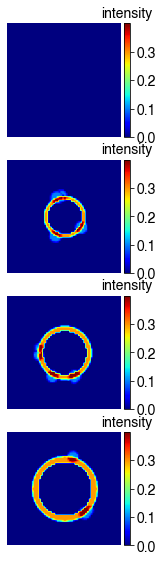

In [5]:
fig6 = plt.figure(figsize=(4 , 3 * len(layer_idx_ls) * 0.8))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = 1)

for idx, layer_idx in enumerate(layer_idx_ls):
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    fig6_ax1.set_xticks(np.arange(0, image_size, 1))
    fig6_ax1.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax1.grid(color='w', linewidth=2)
    fig6_ax1.axis('off')
    pos = fig6_ax1.imshow(grid[layer_idx], cmap='jet', vmin=0, vmax=0.4, extent=[0, 64, 64, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.arange(0,0.4,0.1)
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.ax.tick_params(labelsize=14) 
    cbar.ax.set_title('intensity', size='14')

## combine 10 elements

In [6]:
n_elements_ls = [10]

for n in n_elements_ls:
    element_ls = []
    density_array = np.zeros((n, sample_height_n, sample_size_n, sample_size_n), dtype="float32")
    
    for m in range(n):
        with h5py.File(f'density_element_{m}.h5', 'r') as s:
            densities = s["sample/densities"][...]
            element = s["sample/elements"][0]
        
        density_array[m] = densities
        element_ls.append(element)
        
    with h5py.File(f'density_n_element_{n}.h5', 'w') as s:
        sample = s.create_group("sample")
        sample_v = sample.create_dataset("densities", shape=(n, sample_height_n, sample_size_n, sample_size_n), dtype="f4")
        sample_e = sample.create_dataset("elements", shape=(n,), dtype='S5')
        sample_v[...] = density_array
        sample_e[...] = np.array(element_ls).astype("S5")


In [7]:
f_grid = "density_n_element_10.h5"

with h5py.File(f_grid, "r") as s:
    grid = s["sample/densities"][...]
    elements = s["sample/elements"][...]

    
print(grid.shape)
layer_idx_ls = np.arange(0,64,16)
image_size = grid.shape[-1]
print(np.max(grid))

(10, 64, 64, 64)
0.45000002


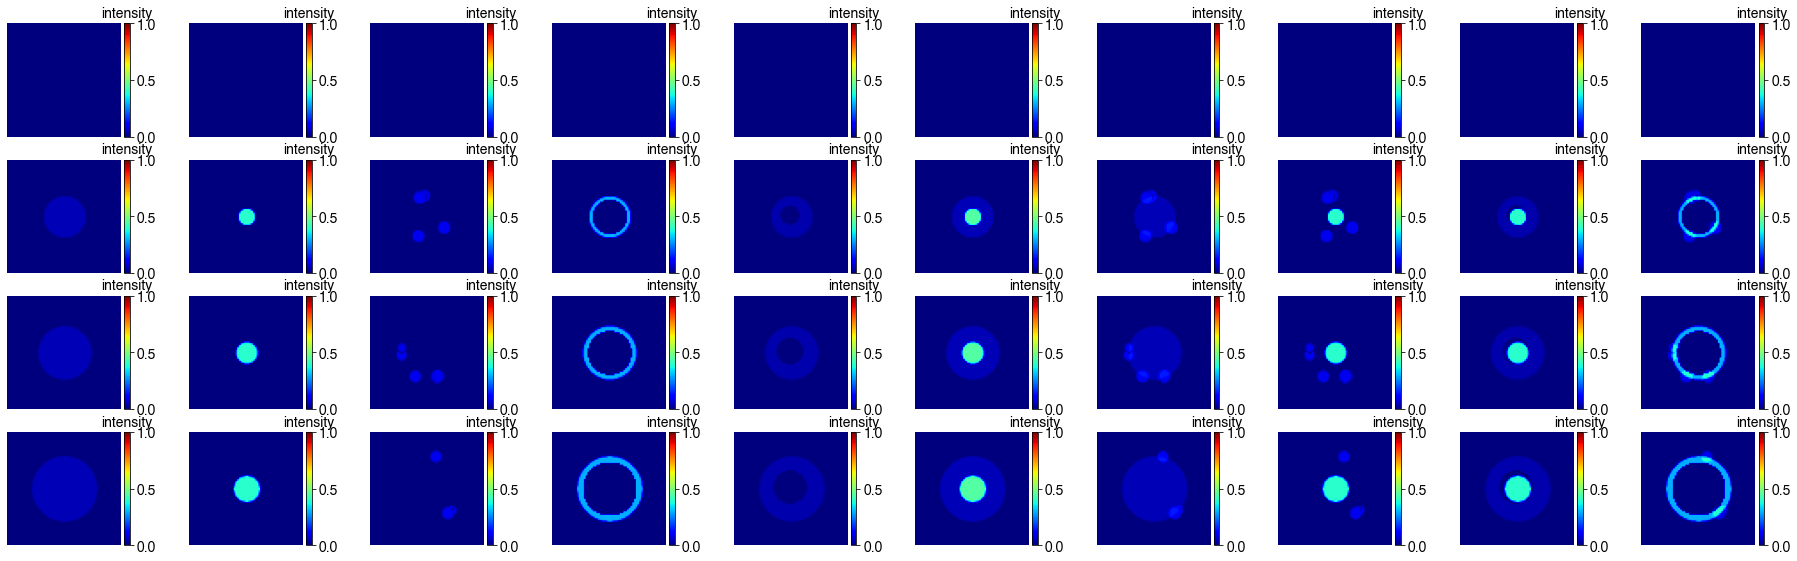

In [8]:
fig6 = plt.figure(figsize=(4 * grid.shape[0] * 0.8 , 3 * len(layer_idx_ls) * 0.8))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = grid.shape[0], width_ratios=[1] * grid.shape[0])

for element_idx in range(grid.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(grid[element_idx,layer_idx], cmap='jet', vmin=0, vmax=1.0, extent=[0, 64, 64, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0,3.0,0.5)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=14) 
        cbar.ax.set_title('intensity', size='14')